In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

os.chdir('/Users/xiao-zy19/Desktop/good_cs')
data = np.fromfile('Good_cplx_spikes.bin', dtype=np.int16).reshape((-1, 128))
print(data.shape)
print(data[:100, 0])

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/xiao-zy19/Desktop/good_cs'

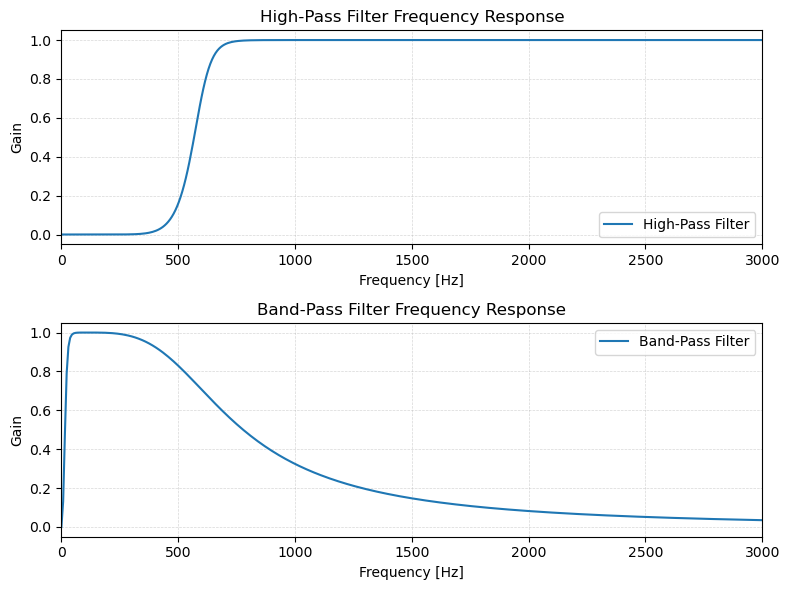

In [15]:
# design filters
from scipy.signal import butter, sosfilt, sosfreqz

# Sample rate and desired cutoff frequencies
fs = 30000  # Sample rate
lowcut = 600  # High-pass filter cutoff frequency
highcut = 600  # High corner frequency for the band-pass filter
lowcut_bp = 20  # Low corner frequency for the band-pass filter

# Butterworth High-Pass Filter
def butter_highpass(cutoff, fs, order=10):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    sos = butter(order, normal_cutoff, btype='high', analog=False, output='sos')
    return sos

# Band-Pass Filter
def butter_bandpass(lowcut_bp, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut_bp / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', analog=False, output='sos')
    return sos

def apply_filter(data, sos):
    y = sosfilt(sos, data)
    return y

# initialize the filters
sos_highpass = butter_highpass(lowcut, fs, order=10)
sos_bandpass = butter_bandpass(lowcut_bp, highcut, fs, order=2)

# Frequency response for the filters
f_hp, h_hp = sosfreqz(sos_highpass, worN=2000, fs=fs)
f_bp, h_bp = sosfreqz(sos_bandpass, worN=2000, fs=fs)

# Plot High and Band-Pass Filter Frequency Response
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.plot(f_hp, abs(h_hp), label="High-Pass Filter")
plt.title('High-Pass Filter Frequency Response')
plt.xlim(0, 3000)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(f_bp, abs(h_bp), label="Band-Pass Filter")
plt.title('Band-Pass Filter Frequency Response')
plt.xlim(0, 3000)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Low Threshold: -34.92749488741177, High Threshold: 2091.9224086244594
Low Crossing Points: [     52      57      68 ... 6122725 6122738 6122762], High Crossing Points: []


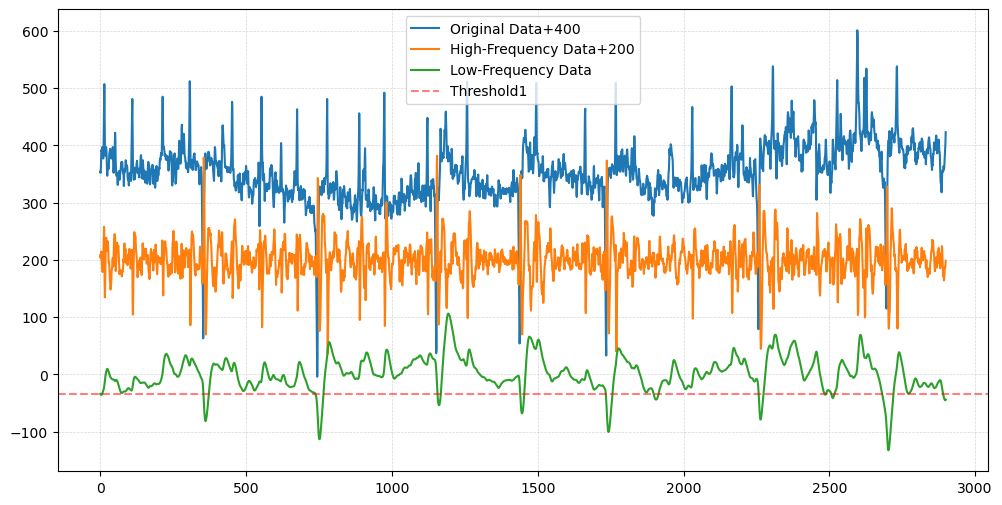

In [16]:
channel_data = data[:, 24]  # Use single channel   1000:100000?

# thresholds
low_threshold = np.mean(channel_data) - 0.5 * np.std(channel_data) 
high_threshold = np.mean(channel_data) + 30 * np.std(channel_data)
low_crossing_points = np.where(np.diff((channel_data < low_threshold).astype(int)) == 1)[0]
high_crossing_points = np.where(np.diff((channel_data > high_threshold).astype(int)) == 1)[0]
# combine the two crossing points
crossing_points = np.sort(np.concatenate((low_crossing_points, high_crossing_points)))
print(f'Low Threshold: {low_threshold}, High Threshold: {high_threshold}')
print(f'Low Crossing Points: {low_crossing_points}, High Crossing Points: {high_crossing_points}')

from scipy.signal import find_peaks
# crossing_points, _ = find_peaks(channel_data, height=threshold, prominence=30)
# print(crossing_points)

low_freq_data = apply_filter(channel_data, sos_bandpass)
high_freq_data = apply_filter(channel_data, sos_highpass)

plt.figure(figsize=(12, 6))
plt.plot(400+channel_data[100:3000], label='Original Data+400')
plt.plot(200+high_freq_data[100:3000], label='High-Frequency Data+200')
plt.plot(low_freq_data[100:3000], label='Low-Frequency Data')
plt.axhline(y=low_threshold, color='r', linestyle='--', label='Threshold1', alpha=0.5)
# plt.axhline(y=high_threshold, color='r', linestyle='--', label='Threshold2', alpha=0.5)
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend()
plt.show()

# threshold = np.mean(low_freq_data) + 2 * np.std(low_freq_data) # threshold
# crossing_points = np.where(np.diff((low_freq_data > threshold).astype(int)) == 1)[0]
# # crossing_points, _ = find_peaks(low_freq_data, height=threshold, prominence=30)

In [17]:
# Parameters for segment extraction
low_pre_ms = 2
low_segment_ms = 10
high_pre_ms = 0.5
high_segment_ms = 2

low_freq_segments = []
high_freq_segments = []

for point in crossing_points:
    # Calculate indices for low-frequency segments, ensuring they don't go out of bounds
    # if indices are out of bounds, skip the segment
    if point - low_pre_ms * fs / 1000 < 0 or point + low_segment_ms * fs / 1000 > len(low_freq_data):
        continue
    start_low = int(point - low_pre_ms * fs / 1000)
    end_low = int(start_low + low_segment_ms * fs / 1000)
    
    # start_low = max(int(point - low_pre_ms * fs / 1000), 0)
    # end_low = min(int(start_low + low_segment_ms * fs / 1000), len(low_freq_data))
    
    
    # Calculate indices for high-frequency segments, ensuring they don't go out of bounds
    start_high = int(point - high_pre_ms * fs / 1000)
    end_high = int(start_high + high_segment_ms * fs / 1000)
    
    # start_high = max(int(point - high_pre_ms * fs / 1000), 0)
    # end_high = min(int(start_high + high_segment_ms * fs / 1000), len(high_freq_data))

    # Extract segments
    low_freq_segments.append(low_freq_data[start_low:end_low])
    high_freq_segments.append(high_freq_data[start_high:end_high])

# Convert lists to arrays
# print(low_freq_segments)
low_freq_segments = np.array(low_freq_segments)
high_freq_segments = np.array(high_freq_segments)
print(f'low freq shape: {low_freq_segments.shape}, high freq shape: {high_freq_segments.shape}')

low freq shape: (152440, 300), high freq shape: (152440, 60)


In [18]:
# align the high_freq_segments
for i, segment in enumerate(high_freq_segments):
    peak_index = np.argmax(segment)  # Find the peak index
    start_adjusted = max(0, peak_index - int(2 * fs / 1000))  # Adjust start
    end_adjusted = min(len(segment), peak_index + int(5 * fs / 1000))  # Adjust end index
    high_freq_segments[i] = segment[start_adjusted:end_adjusted]

In [19]:
from sklearn.decomposition import PCA

# Flatten the segments
low_freq_vectors = low_freq_segments.reshape(low_freq_segments.shape[0], -1)
high_freq_vectors = high_freq_segments.reshape(high_freq_segments.shape[0], -1)
print(f'low freq vectors shape: {low_freq_vectors.shape}, high freq vectors shape: {high_freq_vectors.shape}')

# Perform PCA
pca_low = PCA()
pca_high = PCA()

low_freq_pca = pca_low.fit_transform(low_freq_vectors)
high_freq_pca = pca_high.fit_transform(high_freq_vectors)

low freq vectors shape: (152440, 300), high freq vectors shape: (152440, 60)


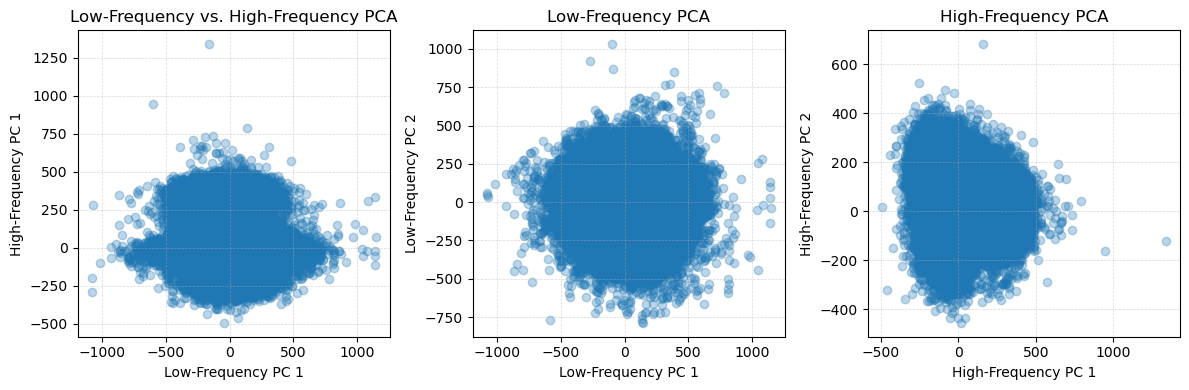

In [20]:
import matplotlib.pyplot as plt

# Plotting PCA results for low-frequency data
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(low_freq_pca[:, 0], high_freq_pca[:, 0], alpha=0.3)
plt.title('Low-Frequency vs. High-Frequency PCA')
# plt.xlim(-500, 500)
# plt.ylim(-500, 500)
plt.xlabel('Low-Frequency PC 1')
plt.ylabel('High-Frequency PC 1')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)

plt.subplot(1, 3, 2)
plt.scatter(low_freq_pca[:, 0], low_freq_pca[:, 1], alpha=0.3)
plt.title('Low-Frequency PCA')
plt.xlabel('Low-Frequency PC 1')
plt.ylabel('Low-Frequency PC 2')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)

plt.subplot(1, 3, 3)
plt.scatter(high_freq_pca[:, 0], high_freq_pca[:, 1], alpha=0.3)
plt.title('High-Frequency PCA')
plt.xlabel('High-Frequency PC 1')
plt.ylabel('High-Frequency PC 2')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.show()

c:\Users\xiao-zy19\anaconda3\envs\bds\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\xiao-zy19\anaconda3\envs\bds\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


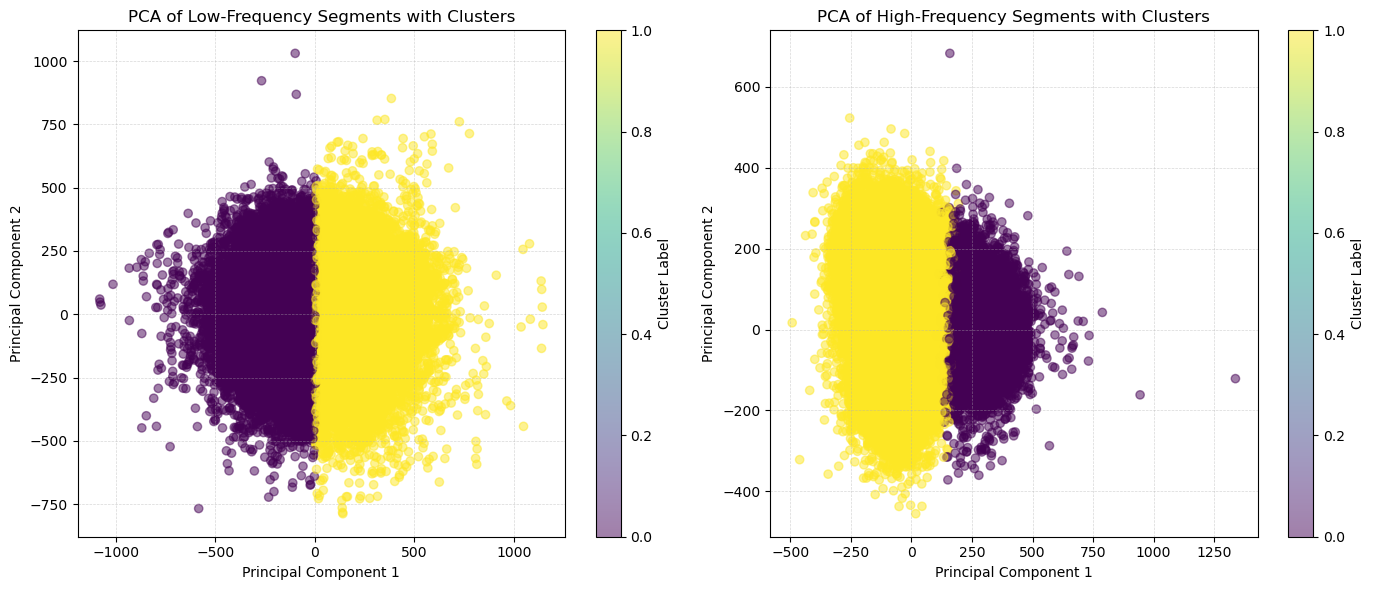

In [21]:
# auto clustering using kmeans?
# seems not a good idea
from sklearn.cluster import KMeans

# Assuming `low_freq_pca` and `high_freq_pca` are your PCA-transformed data for low and high frequency segments

# Define the number of clusters
n_clusters = 2  # Adjust this based on your data and domain knowledge

# Perform K-Means clustering on low-frequency PCA data
kmeans_low = KMeans(n_clusters=n_clusters, random_state=0).fit(low_freq_pca)
labels_low = kmeans_low.labels_

# Perform K-Means clustering on high-frequency PCA data
kmeans_high = KMeans(n_clusters=n_clusters, random_state=0).fit(high_freq_pca)
labels_high = kmeans_high.labels_

# Plotting PCA results for low-frequency data with cluster colors
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(low_freq_pca[:, 0], low_freq_pca[:, 1], c=labels_low, alpha=0.5, cmap='viridis')
plt.title('PCA of Low-Frequency Segments with Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)

# Plotting PCA results for high-frequency data with cluster colors
plt.subplot(1, 2, 2)
plt.scatter(high_freq_pca[:, 0], high_freq_pca[:, 1], c=labels_high, alpha=0.5, cmap='viridis')
plt.title('PCA of High-Frequency Segments with Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.show()

C:\Users\xiao-zy19\AppData\Local\Temp\ipykernel_5132\4151563085.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(low_freq_embedding[:, 0], high_freq_embedding[:, 0], s=5, cmap='Spectral', alpha=0.3)
C:\Users\xiao-zy19\AppData\Local\Temp\ipykernel_5132\4151563085.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(low_freq_embedding[:, 0], low_freq_embedding[:, 1], s=5, cmap='Spectral', alpha=0.3) # , c=labels_low
C:\Users\xiao-zy19\AppData\Local\Temp\ipykernel_5132\4151563085.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(high_freq_embedding[:, 0], high_freq_embedding[:, 1], s=5, cmap='Spectral', alpha=0.3) # , c=labels_high


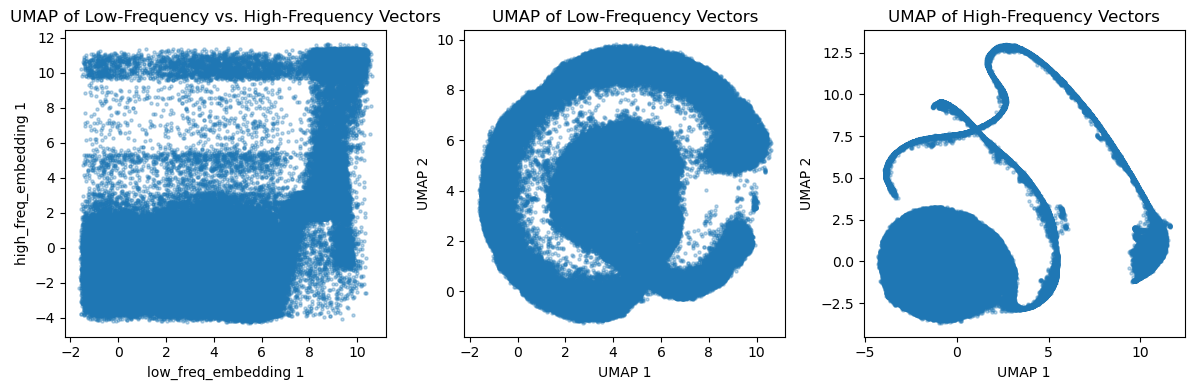

In [24]:
import numpy as np
import umap
import hdbscan
import matplotlib.pyplot as plt

# UMAP for Low-Frequency Vectors
reducer_low = umap.UMAP()
low_freq_embedding = reducer_low.fit_transform(low_freq_vectors)

# UMAP for High-Frequency Vectors
reducer_high = umap.UMAP()
high_freq_embedding = reducer_high.fit_transform(high_freq_vectors)

clusterer_low = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer_low.fit(low_freq_embedding)
labels_low = clusterer_low.labels_

clusterer_high = hdbscan.HDBSCAN(min_cluster_size=50, gen_min_span_tree=True)
clusterer_high.fit(high_freq_embedding)
labels_high = clusterer_high.labels_

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(low_freq_embedding[:, 0], high_freq_embedding[:, 0], s=5, cmap='Spectral', alpha=0.3)
plt.title('UMAP of Low-Frequency vs. High-Frequency Vectors')
plt.xlabel('low_freq_embedding 1')
plt.ylabel('high_freq_embedding 1')

plt.subplot(1, 3, 2)
plt.scatter(low_freq_embedding[:, 0], low_freq_embedding[:, 1], s=5, cmap='Spectral', alpha=0.3) # , c=labels_low
plt.title('UMAP of Low-Frequency Vectors')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.subplot(1, 3, 3)
plt.scatter(high_freq_embedding[:, 0], high_freq_embedding[:, 1], s=5, cmap='Spectral', alpha=0.3) # , c=labels_high
plt.title('UMAP of High-Frequency Vectors')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.tight_layout()
plt.show()

111869


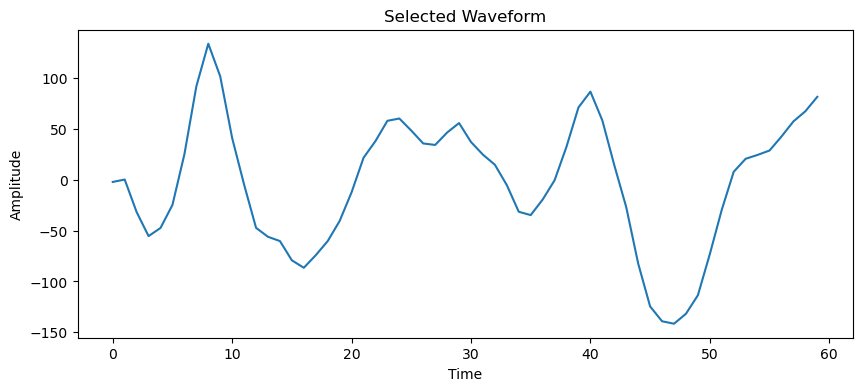

In [23]:
# Plot select point waveforms
selected_point = np.array([0, 10])
distances = np.sqrt(np.sum((high_freq_embedding - selected_point)**2, axis=1))
point_index = np.argmin(distances)
print(point_index)
selected_waveform = high_freq_vectors[point_index]

plt.figure(figsize=(10, 4))
plt.plot(selected_waveform)
plt.title('Selected Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()